# Small transformer from scratch for a classification task.
**Andrés Felipe Guerrero**

**María Márquez Sosa**

This notebook has the goal of understanding the transformer architecture and how to apply it to a basic classification task by constructing all the transformer's modules from scratch using pytorch.

## Location

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/NLP/Proyecto Final/')

In [ ]:
cwd = os.getcwd()
print("Current working directory is:", cwd)

Current working directory is: /content/drive/MyDrive/NLP/Proyecto Final


## 0. Imports

In [ ]:
#!pip install gradio
#!pip install torch

In [ ]:
from IPython.display import Image
import random
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from math import sqrt
%matplotlib inline
import copy


from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch import Tensor

import torch
import torch.nn as nn
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch import tensor
from functools import partial
from typing import Optional, Tuple
from collections import Counter, OrderedDict
from torchtext.vocab import vocab
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from unicodedata import normalize

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import gensim
print(gensim.__version__)
import gensim.downloader as api
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from unicodedata import normalize
nltk.download("stopwords")

import warnings
warnings.filterwarnings("ignore")

import gradio as gr

from unicodedata import normalize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 0.1 Preprocessing

In [ ]:
corpus = ["Nosotros siempre venimos a París",
          "El profesor es de Australia",
          "La mujer vive en Bogotá",
          "Él llego ayer de Taiwán",
          "Ankara es capital de Turquía"
         ]

In [ ]:
def quitartildes(s):
    s = re.sub(
            r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
            normalize( "NFD", s), 0, re.I
        )
    return normalize( 'NFC', s)

In [ ]:
def preprocess_sentence(sentence):
  return quitartildes(sentence).lower().split()

texto_limpio=[preprocess_sentence(sent) for sent in corpus]
texto_limpio

[['nosotros', 'siempre', 'venimos', 'a', 'paris'],
 ['el', 'profesor', 'es', 'de', 'australia'],
 ['la', 'mujer', 'vive', 'en', 'bogota'],
 ['el', 'llego', 'ayer', 'de', 'taiwan'],
 ['ankara', 'es', 'capital', 'de', 'turquia']]

In [ ]:
# Find all unique words in corpus
vocabulary = set(w for s in texto_limpio for w in s)
vocabulary

{'a',
 'ankara',
 'australia',
 'ayer',
 'bogota',
 'capital',
 'de',
 'el',
 'en',
 'es',
 'la',
 'llego',
 'mujer',
 'nosotros',
 'paris',
 'profesor',
 'siempre',
 'taiwan',
 'turquia',
 'venimos',
 'vive'}

In [ ]:
# Add unknown token
vocabulary.add("<unk>")
# Add padding token
vocabulary.add("<pad>")

# pad sentence to desired length
def pad_window(sentence, window_size, pad_token="<pad>"):
  window = [pad_token] * window_size
  return window + sentence + window

In [ ]:
ix_to_word = sorted(list(vocabulary))
word_to_ix = {word: ind for ind, word in enumerate(ix_to_word)}

In [ ]:
def convert_token_to_indices(sentence, word_to_ix):
  return [word_to_ix.get(token, word_to_ix["<unk>"]) for token in sentence]

In [ ]:
# Sentences to indices
example_padded_indices = [convert_token_to_indices(s, word_to_ix) for s in texto_limpio]
example_padded_indices

[[15, 18, 21, 2, 16],
 [9, 17, 11, 8, 4],
 [12, 14, 22, 10, 6],
 [9, 13, 5, 8, 19],
 [3, 11, 7, 8, 20]]

In [ ]:
embedding_dim = 5
embeds = nn.Embedding(len(vocabulary), embedding_dim)

## 1. Scaled dot-product self attention implementation.

#### [a] Construct the basic self-attention dot product

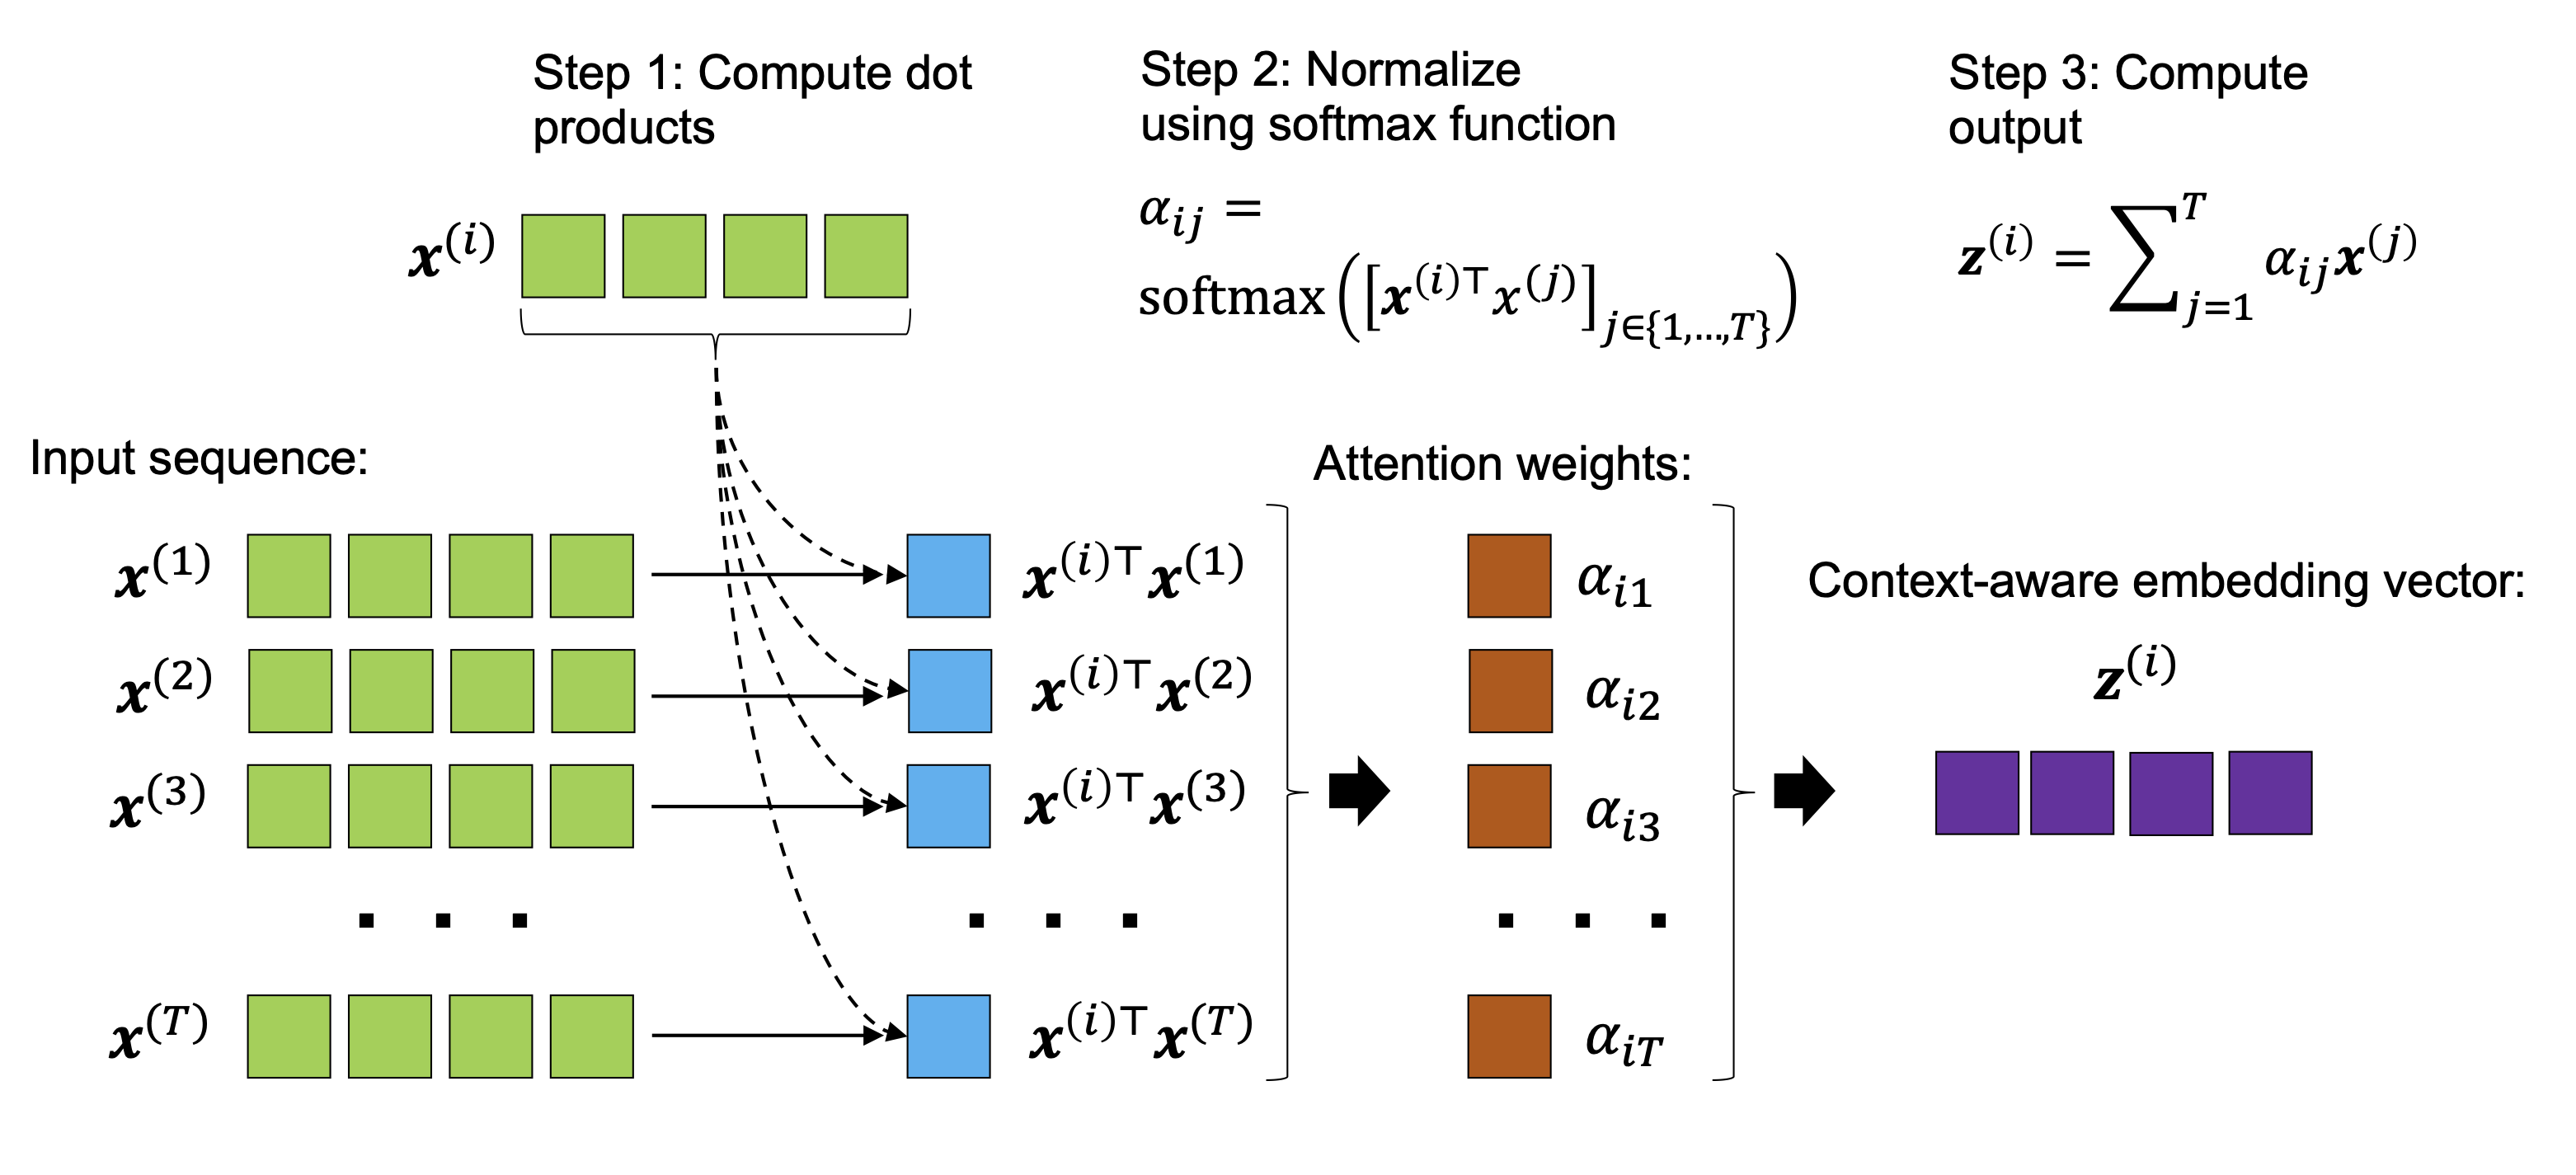

In [ ]:
Image(filename='04.png', width=700)

You should check it with several entry sentences, get the attention weights and calculate the context-aware embedding vector $\bf{z}$.

Bear in mind this self-attention version does **not** learn

In [ ]:
text=torch.tensor(example_padded_indices[0]).view(1,-1)
text

tensor([[15, 18, 21,  2, 16]])

In [ ]:
inputs_embeds = embeds(text)
inputs_embeds.size()

torch.Size([1, 5, 5])

In [ ]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(1,2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    z=torch.matmul(weights, value)
    return z

Create Query, Key and Value with entry vectors

In [ ]:
query = key = value = inputs_embeds
z=scaled_dot_product_attention(query, key, value)
z

tensor([[[ 1.0634,  0.4295,  0.7544,  0.8455, -0.8309],
         [ 1.2968, -2.5142,  0.3354, -0.0206, -0.2376],
         [-0.0682, -0.0272,  0.9151, -0.0540,  0.0722],
         [-0.0839,  0.5016,  1.0707,  0.5766, -0.8243],
         [ 0.6961, -0.2744,  0.7387,  1.1304, -1.4472]]],
       grad_fn=<UnsafeViewBackward0>)

In [ ]:
z.shape

torch.Size([1, 5, 5])

#### [b] Construct the scaled self-attention dot product, but using only one head.

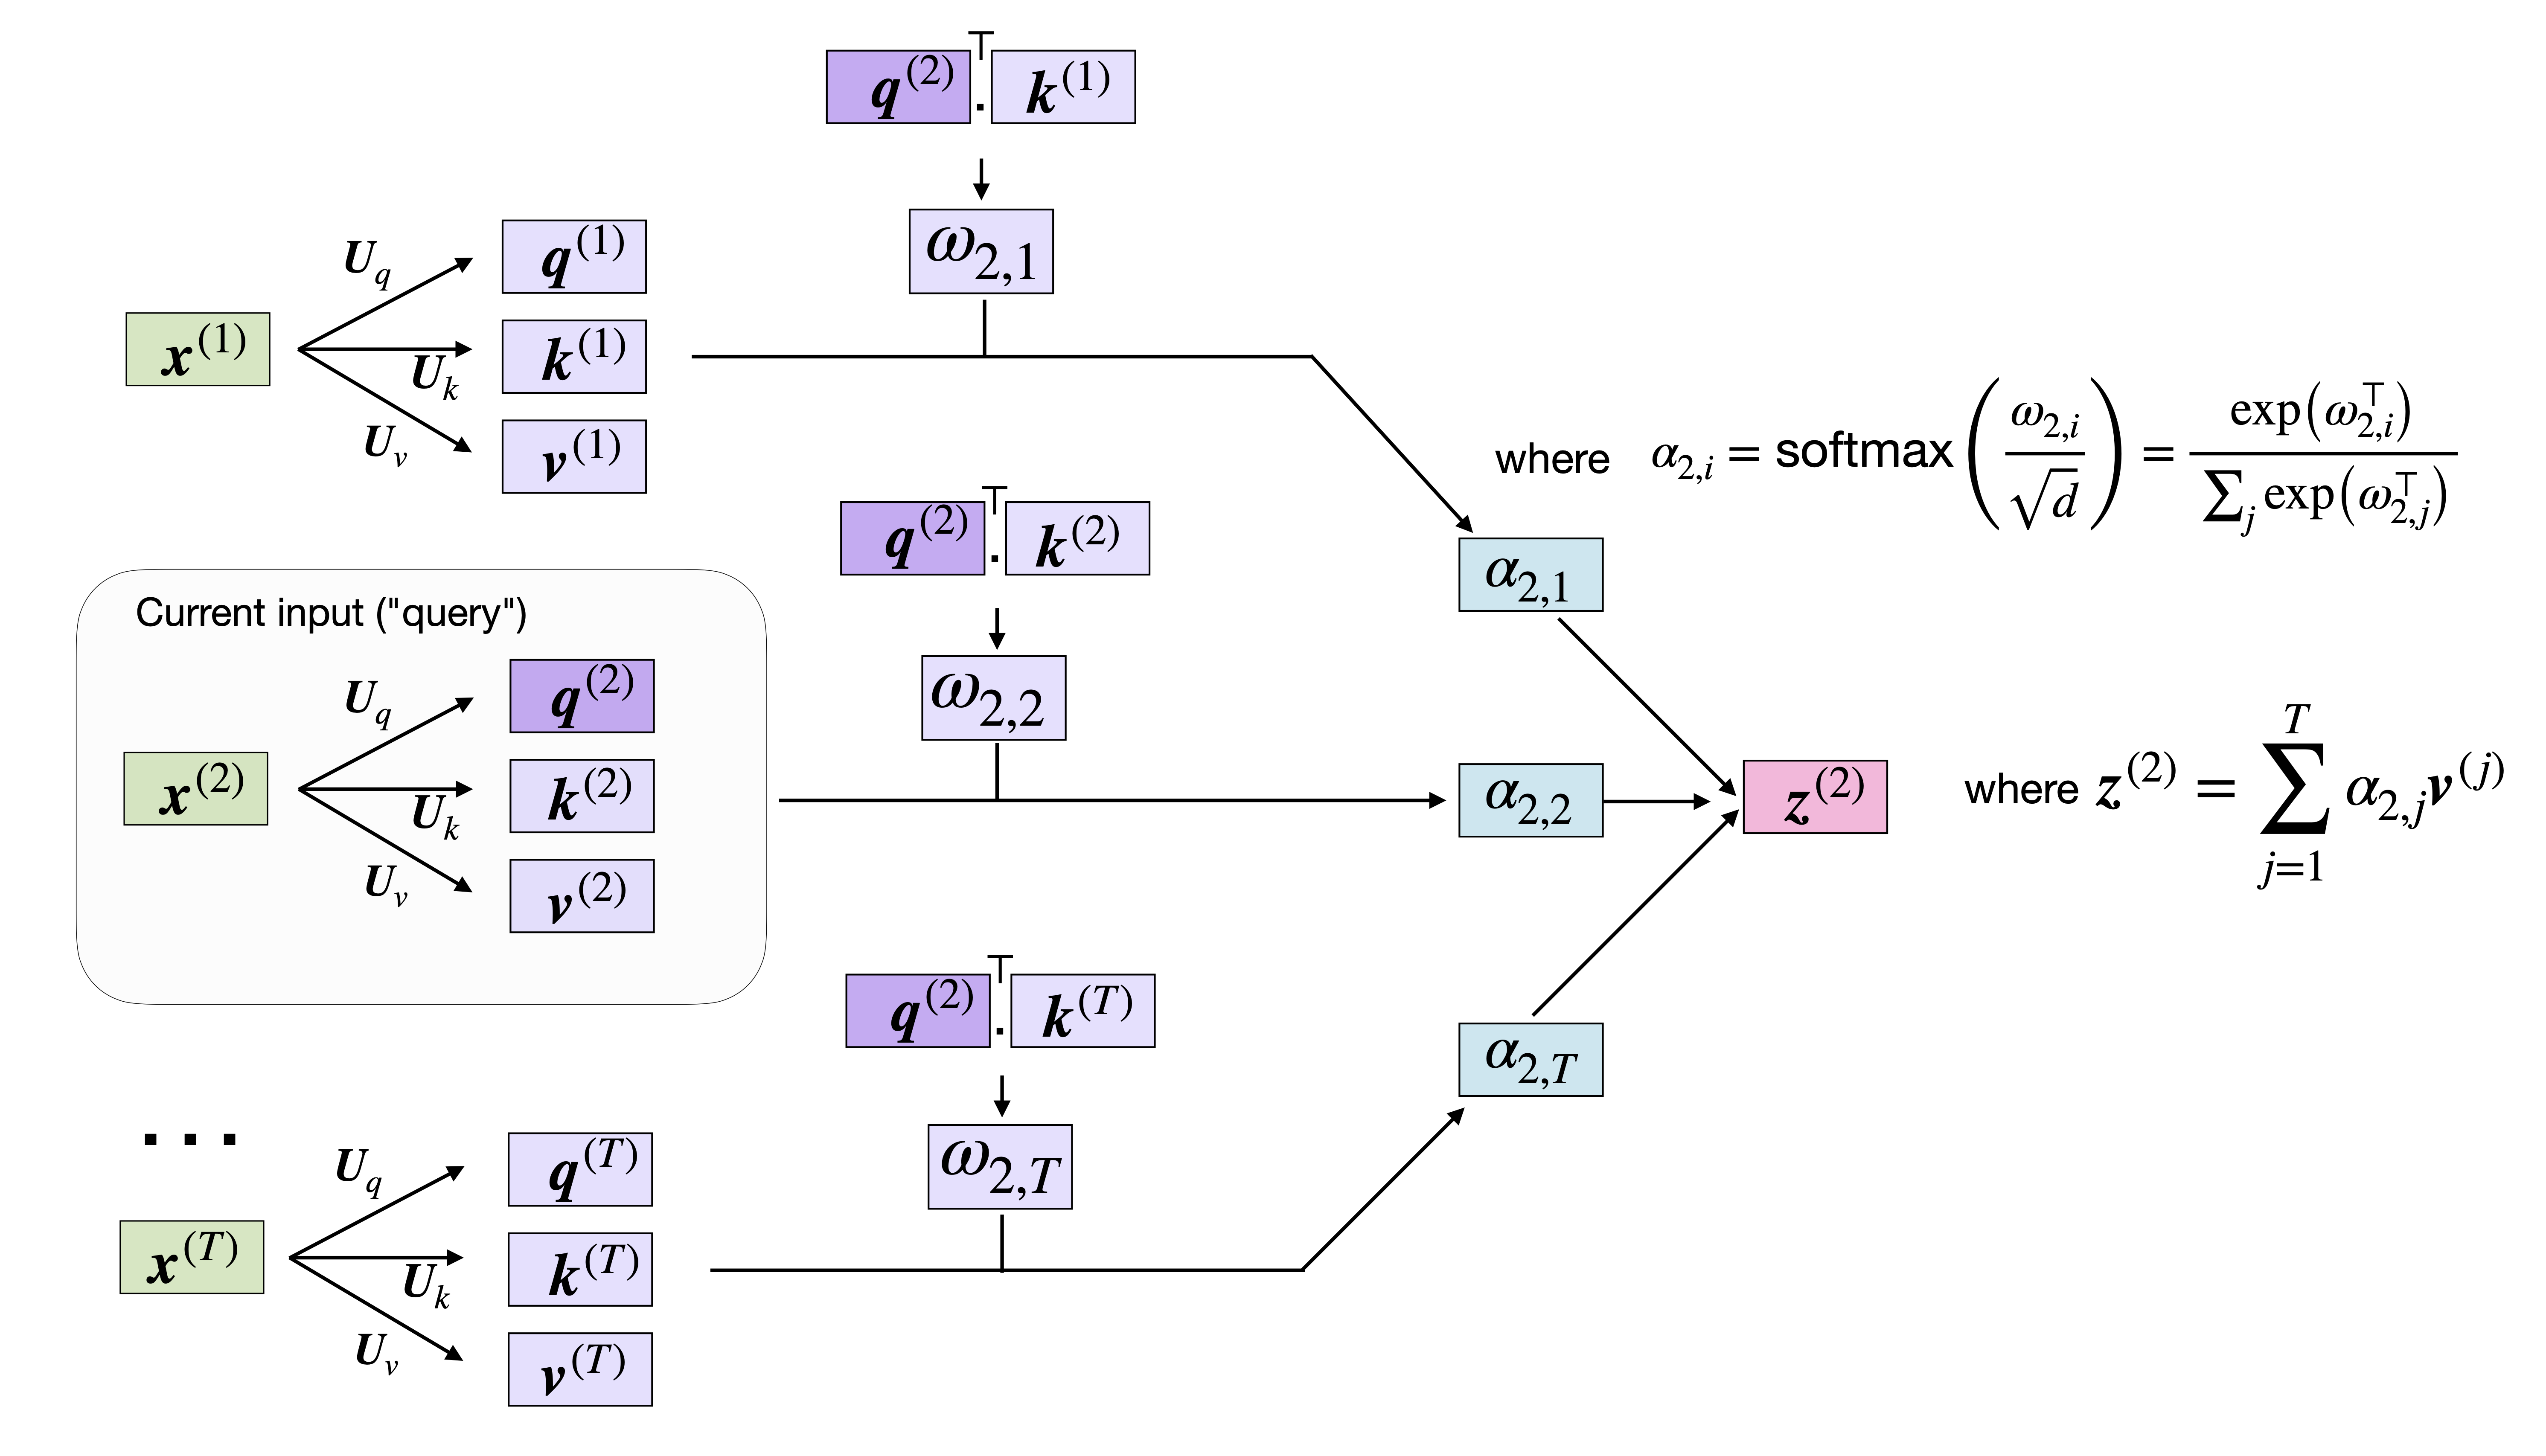

In [ ]:
Image(filename='05.png', width=700)

This mechanism **does** learn, through matrices $U_q$ (query), $U_k$ (key) and $U_v$ (value). It is a type of duplication of entries through linear mappings that will be merged to get the attention weights and weigh the entry value in order to get a new embedding realted to the context of each element of the sequence.

Try with several sentences and get the context vectors. Initial U matrices can be randomly created.

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim,bias=False)

        self.k = nn.Linear(embed_dim, head_dim,bias=False)
        
        self.v = nn.Linear(embed_dim, head_dim,bias=False)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        embed_dim = hidden_size
        num_heads = num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim,bias=False)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

In [ ]:
text1=torch.tensor(example_padded_indices)
text1

tensor([[15, 18, 21,  2, 16],
        [ 9, 17, 11,  8,  4],
        [12, 14, 22, 10,  6],
        [ 9, 13,  5,  8, 19],
        [ 3, 11,  7,  8, 20]])

In [ ]:
inputs_embeds1 = embeds(text1)
inputs_embeds1.size()

torch.Size([5, 5, 5])

In [ ]:
hidden_size=inputs_embeds1.size(dim=1)
num_attention_heads=1
multihead_attn = MultiHeadAttention()
attn_output = multihead_attn(inputs_embeds1)    
attn_output 

tensor([[[-2.0099e-02, -9.9058e-03,  4.0206e-02, -1.3294e-01,  1.5408e-02],
         [-6.5587e-02,  4.4578e-02,  1.1191e-01, -1.2621e-01,  5.8648e-02],
         [-2.9096e-02, -8.3596e-03,  4.6636e-02, -1.4547e-01,  2.4269e-02],
         [-4.4830e-02,  4.0688e-02,  9.0062e-02, -1.2636e-01,  4.1570e-02],
         [-8.6233e-02,  1.2333e-01,  1.7744e-01, -9.6232e-02,  8.2681e-02]],

        [[ 1.8887e-02, -1.1132e-01,  2.5033e-02,  1.7534e-02, -6.5202e-02],
         [ 8.0254e-02, -2.4835e-01, -1.6126e-01,  2.8557e-02, -1.1311e-01],
         [ 2.1232e-02, -1.2621e-01,  1.1700e-02,  3.9151e-02, -6.8483e-02],
         [ 1.5438e-02, -1.2092e-01,  2.5749e-02,  3.7116e-02, -6.4924e-02],
         [ 3.1714e-02, -1.1621e-01, -1.0348e-02,  2.3647e-01, -7.7666e-02]],

        [[-1.2438e-01,  4.2401e-01,  1.9607e-01,  2.1342e-01,  1.9438e-01],
         [-8.3429e-02,  3.0532e-01,  4.8947e-02,  1.4401e-01,  1.6670e-01],
         [-1.1042e-01,  3.7482e-01,  1.4956e-01,  1.6219e-01,  1.8231e-01],
        

In [ ]:
attn_output.size()

torch.Size([5, 5, 5])

## 2. Tweet sentiment classification using transformer

### 2.1 Read dataset

In [ ]:
class TextData(Dataset):
    def __init__(self, filename):
        super(TextData, self).__init__()
        df = pd.read_csv(filename,encoding='latin-1')
        self.df = df[["target", "tweet"]]
        
    def __getitem__(self, index):
        return self.df.iloc[index,0], self.df.iloc[index,1]
    
    def __len__(self):
        return len(self.df)

In [ ]:
#Proprocess, tokenize and remove special characters from text
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = text.split()
    return tokenized

In [ ]:
df = TextData("progressive-tweet-sentiment.csv")
SEED = torch.manual_seed(42)
tr_per = 0.7
train_dataset, valid_dataset = random_split(df,
 [int(len(df)*tr_per),len(df) - int(len(df)*tr_per)], SEED)

In [ ]:
##  Find unique tokens
token_counts = Counter()

for label, line in train_dataset:
    token_counts.update(tokenizer(line))
    
print('Vocab-size:', len(token_counts))
print('Example:', random.choice(list(token_counts.items())))

Vocab-size: 3785
Example: ('tucker', 1)


In [ ]:
sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocabu = vocab(ordered_dict)
vocabu.insert_token("<pad>", 0)
vocabu.insert_token("<unk>", 1)
vocabu.set_default_index(1)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#'Legalization of Abortion', 'Hillary Clinton', 'Feminist Movement', 'Atheism'
text_pipeline = lambda x: [vocabu[token] for token in tokenizer(x)]
label_pipeline = lambda x: 3. if x=='Legalization of Abortion' else (2. if x=='Hillary Clinton' else (1. if x=='Feminist Movement' else 0))


def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), 
                                      dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [ ]:
batch_size = 128
train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)

### 2.2Transformer model

In [ ]:
class TransformerModel(nn.Module):
    # ntoken = size of vocabulary
    # d_model = embedding dimension
    # nhead = number of heads in nn.MultiheadAttention
    # d_hid = dimension of the feedforward network model in nn.TransformerEncoder
    # nlayers = number of transformer layers in nn.TransformerEncoder
    # dropout = dropout probability

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        #PositionalEncoding gives information about token position
        #It has the same dim as the embeddings
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        #Define encoder layer and transformer arch with # of layers
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)

        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        #Output are 4 values, for each class
        self.decoder = nn.Linear(d_model, 4)

        #Initialize weights between -0.1 and 0.1
        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, 4]
        """
        #Get embeddings
        src = self.encoder(src) * math.sqrt(self.d_model)
        
        #Add positional encoding
        src = self.pos_encoder(src)
        #Pass through encoder layers
        output = self.transformer_encoder(src)

        #Flatten using the mean of the vectors
        output = torch.mean(output, dim = 1)
        #Pass through decoder
        output = self.decoder(output)
        return output

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
ntokens = len(vocabu)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 3  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability

model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [ ]:
def train(dataloader):
    model.train()
    total_acc, total_loss = 0., 0.
    start_time = time.time()
    
    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        output = model(text_batch)
        y_pred = torch.argmax(output, 1).float()
        loss = criterion(output, label_batch.long())
        loss.backward()
        optimizer.step()
        
        total_acc += (y_pred==label_batch).float().mean().item()*label_batch.size(0)
        total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)
    
def evaluate(dataloader) -> float:
    model.eval()
    total_acc, total_loss = 0., 0.
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            output = model(text_batch)
            y_pred = torch.argmax(output, 1).float()
            loss = criterion(output, label_batch.long())
            
            total_acc += (y_pred==label_batch).float().mean().item()*label_batch.size(0)
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

In [ ]:
criterion = nn.CrossEntropyLoss() #loss function
lr = 1e-4  # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

best_val_loss = float('inf')
epoch = 100
best_model = None

accuracy_train = []
loss_train_list = []
accuracy_val = []
loss_val_list = []

for epoch in range(epoch):
    epoch_start_time = time.time()
    train_acc, train_loss = train(train_dl)
    val_acc, val_loss= evaluate(valid_dl)
    elapsed = time.time() - epoch_start_time
    
    if epoch%10 ==0:
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid accuracy {val_acc:8.2f}')
        print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
    
    accuracy_train.append(train_acc)
    loss_train_list.append(train_loss)
    accuracy_val.append(val_acc)
    loss_val_list.append(val_loss)

Text(0.5, 1.0, 'Accuracy')

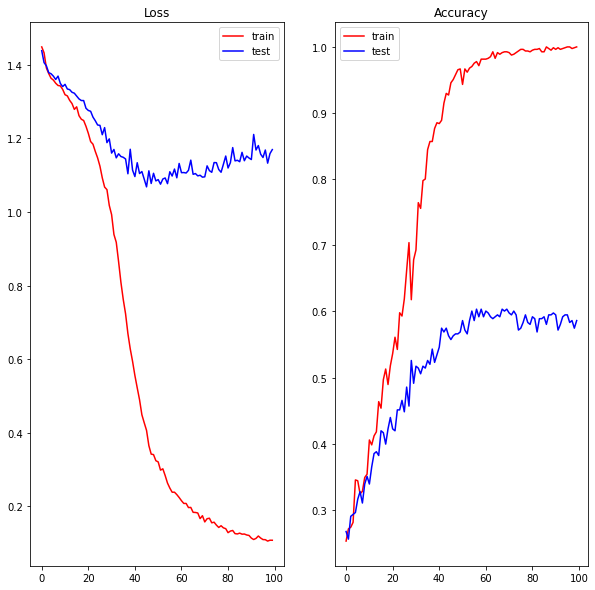

In [ ]:
#Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.plot(range(epoch+1), loss_train_list, 'r', label='train')
ax1.plot(range(epoch+1), loss_val_list, 'b', label = 'test')
ax1.legend()
ax1.set_title('Loss')

ax2.plot(range(epoch+1), accuracy_train, 'r', label='train')
ax2.plot(range(epoch+1), accuracy_val, 'b', label = 'test')
ax2.legend()
ax2.set_title('Accuracy')

### 2.3 Parameter search
Using the created model, this ssection aims to find the parameters that give the best accuracy after 100 epochs. Number of heads, number of repetitions of encoding layer and embedding size are the variables to be modified.

In [ ]:
ntokens = len(vocabu)  # size of vocabulary
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
dropout = 0.2  # dropout probability
criterion = nn.CrossEntropyLoss() #loss function
lr = 1e-4  # learning rate
best_val_loss = float('inf')
num_epoch = 100
best_model = None

metricsmodel = pd.DataFrame(columns=['Número Cabezas', 'Número Capas Encoder', 'Tamaño Embedding','Train loss','Train acc', 'Val loss', 'Val acc'])
Historia = []
i = 0

# Number of heads in nn.MultiheadAttention
for nhead in [5,6]:
    # Number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    for nlayers in [4]:
         # Embedding dimension
        for emsize in [300]:
            i += 1
            accuracy_train = []
            loss_train_list = []
            accuracy_val = []
            loss_val_list = []
            
            model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

            print('=' * 89)
            print(f'| beginning of model {i:3d} |')
            print('=' * 89)

            for epoch in range(num_epoch):
                epoch_start_time = time.time()
                train_acc, train_loss = train(train_dl)
                val_acc, val_loss= evaluate(valid_dl)
                elapsed = time.time() - epoch_start_time
                
                if epoch%50 ==0:
                    print('-' * 89)
                    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
                      f'valid loss {val_loss:5.2f} | valid accuracy {val_acc:8.2f}')
                    print('-' * 89)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = copy.deepcopy(model)

                accuracy_train.append(train_acc)
                loss_train_list.append(train_loss)
                accuracy_val.append(val_acc)
                loss_val_list.append(val_loss)
        
            metricsmodel = metricsmodel.append({'Número Cabezas':nhead, 'Número Capas Encoder':nlayers, 'Tamaño Embedding':emsize,
            'Train loss':train_loss, 'Train acc':train_acc,'Val loss':val_loss, 'Val acc':val_acc}, ignore_index=True)
            Historia.append([accuracy_train, loss_train_list, accuracy_val, loss_val_list])
            

In [ ]:
#Plot
epoch=100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
#for i in range(len(Historia.shape[0])):
ax1.plot(range(num_epoch), Historia[2][0], 'r', label='train')
ax1.plot(range(num_epoch), Historia[2][2], 'b', label = 'validation')
ax2.plot(range(num_epoch), Historia[2][1], 'r', label='train')
ax2.plot(range(num_epoch), Historia[2][3], 'b', label = 'validation')

ax1.legend()
ax1.set_title('Accuracy')
ax2.legend()
ax2.set_title('Loss')

In [ ]:
metricsmodel.sort_values(by=['Val acc'], inplace=True, ascending=False)
metricsmodel.head(10)

### 2.4Graphic interface

In [ ]:
token=('Legalization of Abortion', 'Life is the most important part, please save our #children')
sentences=[tokenizer(s) for s in token]
test_data=DataLoader(sentences, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
test_data

In [ ]:
def getlabel(text):
  ##Aqui va el codigo para poder predecir

  result = lambda x: 'Legalization of Abortion' if x== 3. else ('Hillary Clinton' if x==2. else ('Feminist Movement' if x==1. else 'Other'))
  return result

In [ ]:
def classification_tweets(text):
    text = text.encode("ascii", errors="ignore").decode("ascii")  # remove non-ascii, Chinese characters
    text = text.lower()  # lower case
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\n\n", " ", text)
    text = re.sub(r"\t", " ", text)
    text = text.strip(" ")
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation and special characters
    text = re.sub(" +", " ", text).strip()  # get rid of multiple spaces and replace with a single
    results = getlabel(text)
    return results

In [ ]:
gradio_ui = gr.Interface(
    fn=classification_tweets,
    title="Tweets Classification",
    description="Enter the tweet",
    inputs=gr.inputs.Textbox(lines=10, label="Paste the text here"),
    outputs=[
        gr.outputs.Textbox(label="Class Label"),
    ],
)

In [ ]:
gradio_ui.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`

Using Embedded Colab Mode (NEW). If you have issues, please use share=True and file an issue at https://github.com/gradio-app/gradio/
Note: opening the browser inspector may crash Embedded Colab Mode.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

(<gradio.routes.App at 0x7f71f87fdd10>, 'http://127.0.0.1:7860/', None)